**マスク装着の有無のCNNによる分類**

**参考**
*   https://hajimerobot.co.jp/ai/cnn/
*   https://qiita.com/yakisobamilk/items/686d6ad5ae3285aec639

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Activation, Flatten,MaxPooling2D,Conv2D
from keras import optimizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

In [3]:
keras.__version__

'2.6.0'

**訓練画像、検証画像、テスト画像のディレクトリ**

In [16]:
# 分類クラス
classes = ['WithoutMask', 'WithMask']
nb_classes = len(classes)
batch_size_for_data_generator = 20

base_dir = '/content/drive/MyDrive/kaggle/FaceMaskDetection/FaceMaskDataset'

train_dir = base_dir+'/train'
validation_dir = base_dir+'/validation'
test_dir = base_dir+'/test'

train_WithoutMask_dir = train_dir+'/WithoutMask'
train_WithMask_dir = train_dir+ '/WithMask'

validation_WithoutMask_dir = validation_dir+ '/WithoutMask'
validation_WithMask_dir = validation_dir+ '/WithMask'

test_WithoutMask_dir = test_dir+ '/WithoutMask'
test_WithMask_dir = test_dir+ '/WithMask'

# 平均ぐらいの画像サイズがいいらしい
img_rows, img_cols = 256, 256

**画像データの数を確認する**

In [5]:
print('total training WithoutMask images:', len(os.listdir(train_WithoutMask_dir)),train_WithoutMask_dir)
print('total training WithMask images:', len(os.listdir(train_WithMask_dir)),train_WithMask_dir)
print('\n')
print('total validation WithoutMask images:', len(os.listdir(validation_WithoutMask_dir)),validation_WithoutMask_dir)
print('total validation WithMask images:', len(os.listdir(validation_WithMask_dir)),validation_WithMask_dir)
print('\n')
print('total test WithoutMask images:', len(os.listdir(test_WithoutMask_dir)),test_WithoutMask_dir)
print('total test WithMask images:', len(os.listdir(test_WithMask_dir)),test_WithMask_dir)

total training WithoutMask images: 5000 /content/drive/MyDrive/kaggle/FaceMaskDetection/FaceMaskDataset/train/WithoutMask
total training WithMask images: 5040 /content/drive/MyDrive/kaggle/FaceMaskDetection/FaceMaskDataset/train/WithMask


total validation WithoutMask images: 400 /content/drive/MyDrive/kaggle/FaceMaskDetection/FaceMaskDataset/validation/WithoutMask
total validation WithMask images: 400 /content/drive/MyDrive/kaggle/FaceMaskDetection/FaceMaskDataset/validation/WithMask


total test WithoutMask images: 509 /content/drive/MyDrive/kaggle/FaceMaskDetection/FaceMaskDataset/test/WithoutMask
total test WithMask images: 483 /content/drive/MyDrive/kaggle/FaceMaskDetection/FaceMaskDataset/test/WithMask


**ImageDataGeneratorを使って画像データを拡張する**

In [6]:
train_datagen = ImageDataGenerator(rescale=1.0 / 255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(img_rows, img_cols),color_mode='rgb',classes=classes,class_mode='categorical',batch_size=256,shuffle=True)

Found 10040 images belonging to 2 classes.


In [7]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
validation_generator = test_datagen.flow_from_directory(directory=validation_dir,target_size=(img_rows, img_cols),color_mode='rgb',classes=classes,class_mode='categorical',batch_size=32,shuffle=True)

Found 800 images belonging to 2 classes.


**CNNモデル**

In [8]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_rows, img_cols, 3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(nb_classes,activation='softmax'))
          
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 128)       1

In [9]:
opt = Adam(lr=0.001, decay=1e-6)
model.compile(loss='binary_crossentropy',optimizer= opt, metrics=['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


↑from tensorflow.keras.optimizers import RMSpropじゃないと動かない

https://twitter.com/MC_such/status/1430553055779385350

**学習**

batchSize * steps_per_epoch = 10040
(256*36)

512*18以上だとResourceExhaustedErrorが出る

batchSize * validation_steps = 800
(32*25)

batchSize2ケタ？

機械学習／ディープラーニングにおけるバッチサイズ、イテレーション数、エポック数の決め方
https://qiita.com/kenta1984/items/bad75a37d552510e4682


*   バッチサイズ：データセットのサイズが小さければ32, 64などの小さめの値、大きければ1024, 2048などの大きめの値
*   イテレーション数：バッチサイズによる
*   エポック数：損失関数の値がほぼ収束するまで

In [10]:
history = model.fit(train_generator,steps_per_epoch=36,epochs=50,validation_data=validation_generator,validation_steps=25,verbose=1)

Epoch 1/50
36/36 [==============================] - 2499s 68s/step - loss: 0.2768 - acc: 0.8686 - val_loss: 0.1018 - val_acc: 0.9613
Epoch 2/50
36/36 [==============================] - 316s 9s/step - loss: 0.1016 - acc: 0.9657 - val_loss: 0.0743 - val_acc: 0.9800
Epoch 3/50
36/36 [==============================] - 169s 5s/step - loss: 0.0860 - acc: 0.9704 - val_loss: 0.0507 - val_acc: 0.9850
Epoch 4/50
36/36 [==============================] - 159s 4s/step - loss: 0.0531 - acc: 0.9824 - val_loss: 0.0459 - val_acc: 0.9837
Epoch 5/50
36/36 [==============================] - 157s 4s/step - loss: 0.0470 - acc: 0.9827 - val_loss: 0.0361 - val_acc: 0.9875
Epoch 6/50
36/36 [==============================] - 152s 4s/step - loss: 0.0312 - acc: 0.9879 - val_loss: 0.0171 - val_acc: 0.9937
Epoch 7/50
36/36 [==============================] - 162s 4s/step - loss: 0.0271 - acc: 0.9904 - val_loss: 0.0134 - val_acc: 0.9975
Epoch 8/50
36/36 [==============================] - 163s 5s/step - loss: 0.0219 -

**実行時間**
3h

In [11]:
# 学習結果を保存する
hdf5_file = os.path.join(base_dir, 'mask-model_cnn.hdf5')
model.save_weights(hdf5_file)

**学習推移をグラフに表示する**

In [12]:
import matplotlib.pyplot as plt

In [13]:
%matplotlib inline

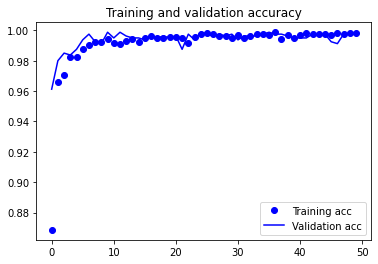

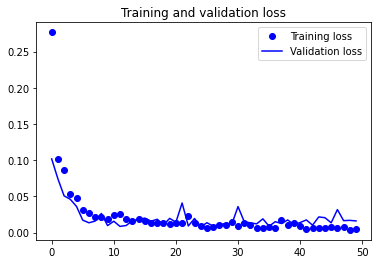

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


**テスト画像データで正答率を調べる**

In [18]:
test_generator = test_datagen.flow_from_directory(directory=test_dir,target_size=(img_rows, img_cols),color_mode='rgb',classes=classes,class_mode='categorical',batch_size=batch_size_for_data_generator)

test_loss, test_acc = model.evaluate(test_generator, steps=50)
print('test acc:', test_acc)

Found 992 images belonging to 2 classes.
50/50 [==============================] - 234s 5s/step - loss: 0.0181 - acc: 0.9980
test acc: 0.9979838728904724
